# T5

In [1]:
import pandas as pd
import numpy as np
import torch
import json
import wandb
from transformers import AutoModelForSequenceClassification, T5Tokenizer, TrainingArguments, DataCollatorWithPadding, Trainer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix,classification_report
from datasets import Dataset, DatasetDict
import datetime

In [2]:
config_data = json.load(open('../config.json'))
HF_TOKEN = config_data['HF_TOKEN']
WANDB_TOKEN = config_data['WANDB_TOKEN']

wandb.login(key=WANDB_TOKEN)

model_name = "google-t5/t5-base"

config = {
    "per_device_train_batch_size":8,
    "per_device_eval_batch_size":8,
    "num_train_epochs":2,
    "learning_rate":5e-5,
    "maxlen": 1000,
    "logging_steps": 10,
    "num_classes": 6,
    "num_labels":6,
    "use_cache":False,
    "pretraining_tp":1,
    "model_name": model_name
}

run = wandb.init(
    project='wz_experimental',
    config=config
)


wandb: Currently logged in as: kawishbit (kawishbit-org). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\kawis\_netrc


In [3]:
id_to_label_mapping = {0: 'A1', 1: 'A2', 2: 'B1', 3: 'B2', 4: 'C1', 5: 'C2'}
label_to_id_mapping = {'A1': 0, 'A2': 1, 'B1': 2, 'B2': 3, 'C1': 4, 'C2': 5}
cefr_levels = ["A1", "A2", "B1", "B2", "C1", "C2"]

In [4]:
train = pd.read_csv('../datasets/quotes/quotes_train.csv')
test = pd.read_csv('../datasets/quotes/quotes_test.csv')
validation = train.sample(2091, random_state=42)
train = train.drop(validation.index)

train = train.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)
validation = validation.sample(frac=1).reset_index(drop=True)

In [5]:
dataset = DatasetDict({
    'train': Dataset.from_pandas(train),
    'val': Dataset.from_pandas(validation),
    'test': Dataset.from_pandas(test)
})
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'level'],
        num_rows: 16130
    })
    val: Dataset({
        features: ['text', 'label', 'level'],
        num_rows: 2091
    })
    test: Dataset({
        features: ['text', 'label', 'level'],
        num_rows: 2692
    })
})

In [6]:
def check_labels_range(dataset):
    unique_labels = set(dataset['train']['label'])
    print(f"Unique labels in the training dataset: {unique_labels}")
    assert all(label in range(6) for label in unique_labels), "Labels must be in the range 0 to 5"

check_labels_range(dataset)

Unique labels in the training dataset: {0, 1, 2, 3, 4, 5}


In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Using device: {device}')

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6, config=config)
model.to(device)
print("Added to device")

Using device: cuda


C:\Users\kawis\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at google-t5/t5-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Added to device


In [8]:
tokenizer = T5Tokenizer.from_pretrained(model_name)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [9]:
# collate_fn = DataCollatorWithPadding(tokenizer=tokenizer)

In [10]:
# def preprocess_function(examples):
#     return tokenizer(examples['text'], truncation=True, max_length=config['maxlen'])
# 
# tokenized_datasets = dataset.map(preprocess_function, batched=True, remove_columns=['text'])
# tokenized_datasets.set_format("torch")

In [11]:
# def compute_metrics(pred):
#     print(pred)
#     print(f'Label: {str(pred.label_ids)[:60]}')
#     print(f'Pred: {str(pred.predictions)[:60]}')
#     print(f'Input: {str(pred.inputs)[:60]}')
#     labels = pred.label_ids
#     predictions = pred.predictions[0].argmax(-1)
# 
#     m_accuracy = accuracy_score(labels, predictions)
# 
#     precision = precision_score(labels, predictions, average='weighted')
#     recall = recall_score(labels, predictions, average='weighted')
#     f1 = f1_score(labels, predictions, average='weighted')
# 
#     return {
#         'accuracy': m_accuracy,
#         'precision': precision,
#         'recall': recall,
#         'f1': f1
#     }

In [12]:
# training_args = TrainingArguments(
#     output_dir='./results',
#     evaluation_strategy = 'epoch',
#     save_strategy = 'epoch',
#     logging_steps=config['logging_steps'],
#     per_device_train_batch_size=config['per_device_train_batch_size'],
#     per_device_eval_batch_size=config['per_device_eval_batch_size'],
#     num_train_epochs=config['num_train_epochs'],
#     fp16=True,
#     report_to="wandb",
#     load_best_model_at_end=True,
#     metric_for_best_model='accuracy',
#     learning_rate=config['learning_rate'],
# )

In [13]:
# trainer = Trainer(
#     model = model,
#     args = training_args,
#     train_dataset = tokenized_datasets['train'].shuffle(seed=42),
#     eval_dataset = tokenized_datasets['val'].shuffle(seed=42),
#     tokenizer = tokenizer,
#     data_collator = collate_fn,
#     compute_metrics = compute_metrics
# )

In [14]:
# train_result = trainer.train()

In [15]:
# trainer.evaluate()

In [16]:
model.config.use_cache = True

In [17]:
# trainer.save_model('model')
# tokenizer.save_pretrained('model')

In [18]:
def make_predictions(p_model, p_test):
    print(f'Started prediction at {datetime.datetime.now()}')
    sentences = p_test.text.tolist()

    batch_size = 32

    all_outputs = []

    for i in range(0, len(sentences), batch_size):
        batch_sentences = sentences[i:i + batch_size]

        inputs = tokenizer(batch_sentences, return_tensors="pt", padding=True, truncation=True, max_length=1000)

        inputs = {k: v.to('cuda' if torch.cuda.is_available() else 'cpu') for k, v in inputs.items()}

        with torch.no_grad():
            outputs = p_model(**inputs)
            all_outputs.append(outputs['logits'])

    final_outputs = torch.cat(all_outputs, dim=0)
    p_test['predictions']=final_outputs.argmax(axis=1).cpu().numpy()
    p_test['predictions']=p_test['predictions'].apply(lambda l:id_to_label_mapping[l])


make_predictions(model,test)

Started prediction at 2024-08-31 22:02:51.545357


Accuracy: 0.276
Accuracy for label A1: 0.654
Accuracy for label A2: 0.004
Accuracy for label B1: 0.005
Accuracy for label B2: 0.366
Accuracy for label C1: 0.000
Accuracy for label C2: 0.000

Classification Report:
              precision    recall  f1-score   support

          A1       0.32      0.65      0.43       853
          A2       0.33      0.00      0.01       753
          B1       0.09      0.00      0.01       442
          B2       0.19      0.37      0.25       492
          C1       0.00      0.00      0.00       142
          C2       0.00      0.00      0.00        10

    accuracy                           0.28      2692
   macro avg       0.16      0.17      0.12      2692
weighted avg       0.25      0.28      0.19      2692


Confusion Matrix:
[[558   4  10 281   0   0]
 [477   3   8 265   0   0]
 [289   1   2 150   0   0]
 [309   1   2 180   0   0]
 [ 86   0   1  55   0   0]
 [  7   0   0   3   0   0]]


C:\Users\kawis\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\kawis\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\kawis\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\kawis\anaconda3\Lib\site-packag

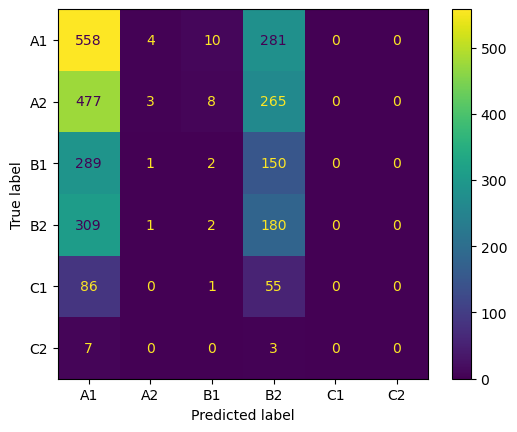

In [19]:
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import wandb

train['level'] = train['label'].apply(lambda x: id_to_label_mapping[x])
test['level'] = test['label'].apply(lambda x: id_to_label_mapping[x])

y_pred = test['predictions']

y_true = test['level']

def map_func(x):
    return label_to_id_mapping.get(x, -1)

y_true_mapped = np.vectorize(map_func)(y_true)
y_pred_mapped = np.vectorize(map_func)(y_pred)

accuracy = accuracy_score(y_true=y_true_mapped, y_pred=y_pred_mapped)
print(f'Accuracy: {accuracy:.3f}')

unique_labels = set(y_true_mapped)

for label in unique_labels:
    label_indices = [i for i in range(len(y_true_mapped)) if y_true_mapped[i] == label]
    label_y_true = [y_true_mapped[i] for i in label_indices]
    label_y_pred = [y_pred_mapped[i] for i in label_indices]
    label_accuracy = accuracy_score(label_y_true, label_y_pred)
    print(f'Accuracy for label {cefr_levels[label]}: {label_accuracy:.3f}')

class_report = classification_report(y_true=y_true_mapped, y_pred=y_pred_mapped, target_names=cefr_levels, labels=list(range(len(cefr_levels))))
class_report_dict = classification_report(y_true=y_true_mapped, y_pred=y_pred_mapped, target_names=cefr_levels, labels=list(range(len(cefr_levels))), output_dict=True)


print('\nClassification Report:')
print(class_report)


table_data = []

for key, value in class_report_dict.items():
    if isinstance(value, dict):
        table_data.append([
            key,
            value.get("precision", 0),
            value.get("recall", 0),
            value.get("f1-score", 0),
            value.get("support", 0)
        ])
    else:
        table_data.append([
            key,
            0,
            0,
            value,
            class_report_dict["weighted avg"]["support"]
        ])

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true=y_true_mapped, y_pred=y_pred_mapped, labels=list(range(len(cefr_levels))))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=cefr_levels)
disp.plot()


print('\nConfusion Matrix:')
print(conf_matrix)

wandb.log({
    "Class Proportions": wandb.sklearn.plot_class_proportions(train['level'], test['level'], cefr_levels),
    "Confusion Matrix": plt,
    "Classification Report": wandb.Table(data=table_data, columns=['Class/Metric', 'Precision', 'Recall', 'F1-score', 'Support'])
})

In [20]:
print(f'Ended prediction at {datetime.datetime.now()}')
wandb.finish()

Ended prediction at 2024-08-31 22:03:14.535448
